# Semantic Segmentation with Captum

In this tutorial, we demonstrate applying Captum to semantic segmentation task, to understand what pixels and regions contribute to the labeling of a particular class. We explore applying GradCAM as well as Feature Ablation to a pretrained Fully-Convolutional Network model with a ResNet-101 backbone.

  **Note:** Before running this tutorial, please install torchvision and PIL.

Initial Imports:

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np

from torchvision import models
from torchvision import transforms

from captum.attr import visualization as viz
from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, LayerAttribution

# Default device
device = "cuda:0" if torch.cuda.is_available() else "cpu"

We can now load the pre-trained segmentation model from torchvision, which is trained on a subset of COCO Train 2017 and define input preprocessing transforms.

In [2]:
fcn = models.segmentation.fcn_resnet101(pretrained=True).to(device).eval()
fcn

d:\miniconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [3]:
# Input preprocessing transformation
preprocessing = transforms.Compose([
    transforms.Resize(640),
    transforms.ToTensor()]
                                )
normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225]
)

We define a few helper methods to visualize segmentation results. 
(Source: https://www.learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/)

In [4]:
# This method allows us to visualize a particular segmentation output, by setting
# each pixels color according to the given segmentation class provided in the
# image (segmentation output).
def decode_segmap(image, nc=21):
    # image： [H, W]
    label_colors = np.array([(0, 0, 0),  # 0=background
        # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
        (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
        # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
        (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
        # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
        (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
        # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
        (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)]
    )

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

Let us now obtain an image from the COCO training set to evaluate and interpret the segmentation model.

In [5]:
# !wget -nv --directory-prefix=images/ https://farm8.staticflickr.com/7301/8862358875_eecba9fb10_z.jpg

Display original image

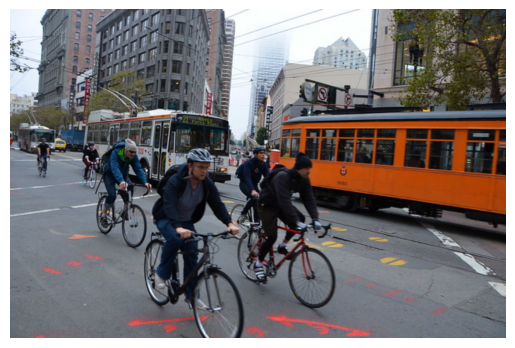

In [6]:
img = Image.open("images/8862358875_eecba9fb10_z.jpg")
preprocess_img = preprocessing(img)
plt.imshow(preprocess_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

We now normalize the input image and compute and visualize the image segmentation output.

In [7]:
# Normalize image and compute segmentation output
normalized_input = normalize(preprocess_img).unsqueeze(0).to(device)
normalized_input.requires_grad = True

In [8]:
out = fcn(normalized_input)['out']
out.shape

torch.Size([1, 21, 640, 966])

In [9]:
# Find most likely segmentation class for each pixel.
out_max = torch.argmax(out, dim=1, keepdim=True)
out_max.shape

torch.Size([1, 1, 640, 966])

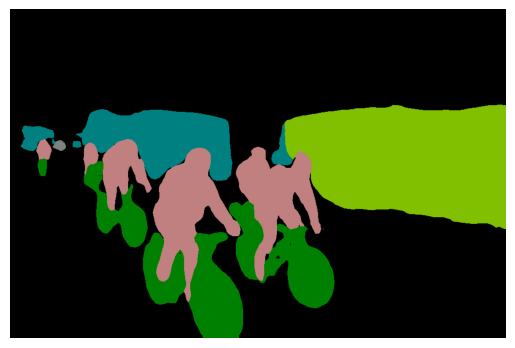

In [10]:
# Visualize segmentation output using utility method.
rgb = decode_segmap(out_max.detach().cpu().squeeze().numpy())
plt.imshow(rgb)
plt.axis('off')
plt.show()

We see that the segmentation model has identified regions including humans, bicicyles, trucks, and cars. We will now interpret the model using Captum to understand what pixels contribute to these predictions.

---

我们看到分割模型已经识别出包括人类、自行车、卡车和汽车在内的区域。 我们现在将使用 Captum 解释模型，以了解哪些像素对这些预测有贡献。

## Interpreting with Captum

A challenge with applying Captum to segmentation models is that we need to attribute with respect to a single scalar output, such as a target logit in classification cases. With segmentation models, the model output is the size of the input image.

One way to compute attribution is with respect to a particular pixel output score for a given class. This is the right approach if we want to understand the influences for a particular pixel, but we often want to understand the prediction of an entire segment, as opposed to attributing each pixel independently.

This can be done in a few ways, the simplest being summing the output logits of each channel, corresponding to a total score for each segmentation class, and attributing with respect to the score for the particular class. This approach is simple to implement, but could result in misleading attribution when a pixel is not predicted as a certain class but still has a high score for that class. Based on this, we sum only the scores corresponding to pixels that are predicted to be a particular class (argmax class) and attribute with respect to this sum. We define a wrapper function that performs this, and can use this wrapper for attribution instead of the original model.

---

将 Captum 应用于分割模型的一个挑战是，我们需要对单个标量输出进行归因，例如分类案例中的目标 Logit。 对于分割模型，模型输出是输入图像的大小。

计算归因的一种方法是针对给定类别的特定像素输出分数。 如果我们想要了解特定像素的影响，但我们通常想要了解整个片段的预测，而不是独立地归因每个像素，那么这是正确的方法。

这可以通过几种方式来完成，最简单的是将每个通道的输出 logits 相加，对应于每个分割类别的总分，并根据特定类别的分数进行归因。 这种方法实现起来很简单，但是当像素没有被预测为某个类别但仍然具有该类别的高分时，可能会导致误导性的归因。 基于此，我们仅将与预测为特定类别（argmax 类别）的像素相对应的分数以及相对于该总和的属性求和。 我们定义一个执行此操作的包装函数，并且可以使用该包装函数代替原始模型进行归因。

In [11]:
"""
This wrapper computes the segmentation model output and sums the pixel scores for
all pixels predicted as each class, returning a tensor with a single value for
each class. This makes it easier to attribute with respect to a single output
scalar, as opposed to an individual pixel output attribution.
"""
def agg_segmentation_wrapper(input):
    model_out = fcn(input)['out']
    # Creates binary matrix with 1 for original argmax class for each pixel
    # and 0 otherwise. Note that this may change when the input is ablated
    # so we use the original argmax predicted above, out_max.
    selected_inds = torch.zeros_like(model_out[0:1]).scatter_(1, out_max, 1)
    return (model_out * selected_inds).sum(dim=(2, 3))


# Alternate wrapper, simply summing each output channel
# def wrapper(inp):
#   return fcn(inp)['out'].sum(dim=(2,3))


We can now construct a LayerGradCAM attribution object using the wrapper, as well as the desired convolution layer for attribution. Generally, the final convolution layer is used for GradCAM attribution.

---

我们现在可以使用包装器构建 LayerGradCAM 归因对象，以及所需的归因卷积层。 一般最后的卷积层用于GradCAM归因。

In [12]:
lgc = LayerGradCam(forward_func=agg_segmentation_wrapper, layer=fcn.backbone.layer4[2].conv3)
lgc

We can now compute LayerGradCAM attributions by providing the preprocessed input and the desired target segmentation class (between 0 and 20), which is the index of the output.

In this example, we attribute with respect to target=6, which corresponds to bus. See the decode_segmap helper method for a mapping of target class indices to text.

---

现在，我们可以通过提供预处理的输入和所需的目标分割类（0 到 20 之间）（即输出的索引）来计算 LayerGradCAM 属性。

在这个例子中，我们对 target=6 进行属性，它对应于总线。 有关目标类索引到文本的映射，请参阅decode_segmap 辅助方法。

In [13]:
# 6: bus
gc_attr = lgc.attribute(inputs=normalized_input, target=6)
gc_attr.shape

torch.Size([1, 1, 80, 121])

We can first confirm that the Layer GradCAM attributions match the dimensions of the layer activations. We can obtain the intermediate layer activation using the LayerActivation attribution method.

---

我们可以首先确认 Layer GradCAM 属性与层激活的维度相匹配。 我们可以使用LayerActivation归因方法获得中间层激活。

In [14]:
la = LayerActivation(forward_func=agg_segmentation_wrapper, layer=fcn.backbone.layer4[2].conv3)
activation = la.attribute(inputs=normalized_input)
activation.shape

torch.Size([1, 2048, 80, 121])

In [15]:
print("Input Shape:", normalized_input.shape)
print("Layer Activation Shape:", activation.shape)
print("Layer GradCAM Shape:", gc_attr.shape)

Input Shape: torch.Size([1, 3, 640, 966])
Layer Activation Shape: torch.Size([1, 2048, 80, 121])
Layer GradCAM Shape: torch.Size([1, 1, 80, 121])


We can now visualize the Layer GradCAM attributions using the Captum visualization utilities.

---

我们现在可以使用 Captum 可视化实用程序来可视化 Layer GradCAM 属性。

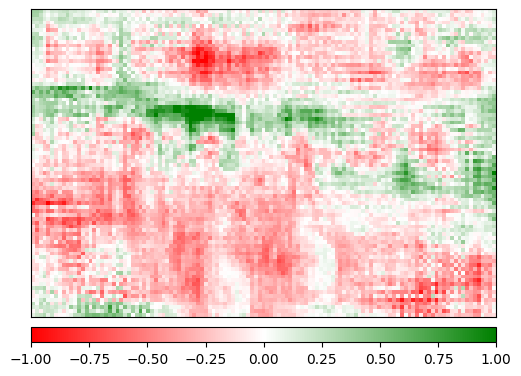

(<Figure size 600x600 with 2 Axes>, <Axes: >)

In [16]:
viz.visualize_image_attr(
    attr=gc_attr[0].cpu().permute(1, 2, 0).detach().numpy(),
    sign="all",         # [positive, absolute_value, negative, all]
    show_colorbar=True,
)

We'd like to understand this better by overlaying it on the original image. In order to do this, we need to upsample the layer GradCAM attributions to match the input size.

---

我们希望通过将其叠加在原始图像上来更好地理解这一点。 为此，我们需要对 GradCAM 层属性进行上采样以匹配输入大小。

In [17]:
upsampled_gc_attr = LayerAttribution.interpolate(gc_attr, normalized_input.shape[2:])
print("Upsampled Shape:", upsampled_gc_attr.shape)

Upsampled Shape: torch.Size([1, 1, 640, 966])


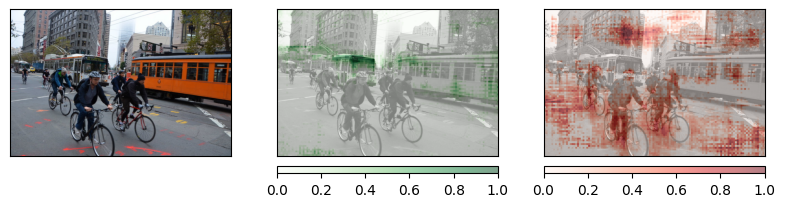

(<Figure size 800x600 with 6 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [18]:
viz.visualize_image_attr_multiple(
    attr=upsampled_gc_attr[0].cpu().permute(1, 2, 0).detach().numpy(),
    original_image=preprocess_img.permute(1, 2, 0).numpy(),
    methods=["original_image", "blended_heat_map", "blended_heat_map"], # [heat_map, blended_heat_map, original_image, masked_image, alpha_scaling]
    signs=["all", "positive", "negative"],                              # [positive, absolute_value, negative, all]
    show_colorbar=True,
)

We can now attribute using a perturbation-based method, Feature Ablation to interpret the model in a different way. The idea of feature ablation is to ablate each feature by setting it equal to some baseline value (e.g. 0) and compute the difference in output with and without the feature. This can be done pixel-wise, but that can often by computationally intensive for large images. We also provide the option to group features and ablate them together. In this case, we can group pixels based on their segmentation class to understand how the presence of each class affects a particular output.

---

我们现在可以使用基于扰动的方法（特征消除）进行归因，以不同的方式解释模型。 特征消融的想法是通过将每个特征设置为等于某个基线值（例如 0）来消融每个特征，并计算具有和不具有该特征的输出差异。 这可以逐像素完成，但对于大图像来说，这通常需要大量计算。 我们还提供了对功能进行分组并将它们合并在一起的选项。 在这种情况下，我们可以根据像素的分割类别对像素进行分组，以了解每个类别的存在如何影响特定的输出。

To better understand how this ablation works, let us consider ablating the train class of the segmentation output and visualize the result.

---

为了更好地理解这种消融的工作原理，让我们考虑消融分割输出的训练类并可视化结果。

In [19]:
torch.unique(out_max)

tensor([ 0,  2,  6,  7, 15, 19], device='cuda:0')

In [20]:
# 去除类别为 19: train 的像素
mask = (out_max != 19).float()[0].cpu()
mask

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

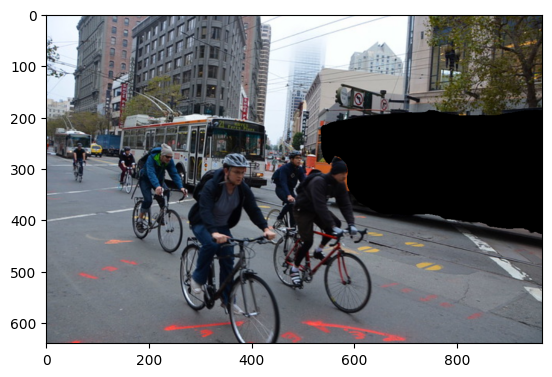

In [21]:
img_without_train = mask * preprocess_img
plt.imshow(img_without_train.permute(1, 2, 0))

Feature ablation performs this process on each segment, comparing the output with and without ablating the segment. All pixels in the segment have the same attribution score corresponding to the change in output. This can be done using the FeatureAblation attribution class. We provide a feature mask defining the desired grouping of pixels (based on output class of each pixel). The perturbations_per_eval argument controls the number of perturbations processed in one batch, this may need to be set to a lower value if limited memory is available.
**Note**: This may take up to a few minutes to complete.

---

特征消融对每个段执行此过程，比较消融该段和未消融该段的输出。 该段中的所有像素都具有与输出变化相对应的相同归因分数。 这可以使用FeatureAblation 归因类来完成。 我们提供一个特征掩码，定义所需的像素分组（基于每个像素的输出类别）。 perturbations_per_eval 参数控制一批中处理的扰动数量，如果可用内存有限，则可能需要将其设置为较低的值。
**注意**：这可能需要几分钟才能完成。

In [22]:
fa = FeatureAblation(forward_func=agg_segmentation_wrapper)
fa_attr = fa.attribute(
    inputs=normalized_input,
    feature_mask=out_max,
    perturbations_per_eval=2,
    target=6
)

We can now visualize the attributions based on Feature Ablation.

---

我们现在可以基于特征消融可视化归因。

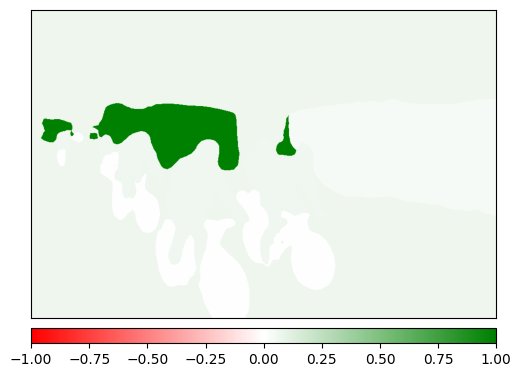

(<Figure size 600x600 with 2 Axes>, <Axes: >)

In [24]:
viz.visualize_image_attr(
    attr=fa_attr[0].cpu().detach().permute(1,2,0).numpy(),
    sign="all", # [positive, absolute_value, negative, all]
    show_colorbar=True,
)

Clearly, the bus region is most salient as expected, since that is the target we are interpreting. To better visualize the relative importance of the remaining regions, we can set the attributions of the bus area to 0 and visualize the remaining area.

---

显然，正如预期的那样，公交车区域最为突出，因为这是我们正在解释的目标。 为了更好地可视化剩余区域的相对重要性，我们可以将 bus 区域的属性设置为0并可视化剩余区域。

In [25]:
# 忽略bus区域
fa_attr_without_max = (out_max != 6).float()[0] * fa_attr

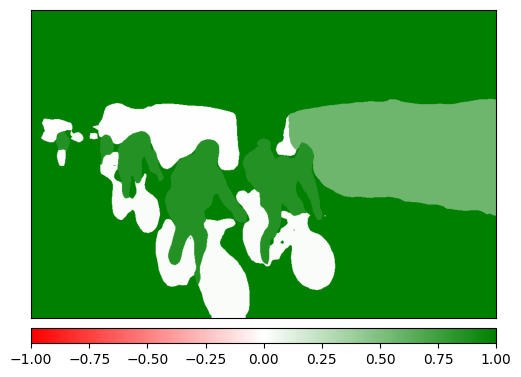

(<Figure size 600x600 with 2 Axes>, <Axes: >)

In [28]:
viz.visualize_image_attr(
    fa_attr_without_max[0].cpu().detach().permute(1, 2, 0).numpy(),
    sign="all", # [positive, absolute_value, negative, all]
    show_colorbar=True,
)

Between the remaining regions, it seems that the background and humans contribute positively to the bus prediction, as does the train. Ablating the bicycle appears to have no effect on the bus prediction.

---

在其余区域之间，背景和人类似乎对公交车预测做出了积极贡献，火车也是如此。 消除自行车似乎对公交车预测没有影响。